In [3]:
import numpyro
import jax
import jax.numpy as np
from numpyro.contrib.autoguide import AutoDelta
from numpyro.infer.util import init_with_noise, init_to_value
import numpyro
from numpyro.infer import ELBO
import numpyro.distributions as dist
from numpyro.infer.stein import SVGD
from numpyro.infer.kernels import RBFKernel
from numpyro.optim import Adam
from tqdm import tqdm
import matplotlib.pyplot as plt

In [4]:
def funnel(dim=10):
    y = numpyro.sample('y', dist.Normal(0, 3))
    numpyro.sample('x', dist.Normal(np.zeros(dim - 1), np.exp(y / 2)))

In [6]:
dim = 10
rng_key = jax.random.PRNGKey(142)
guide = AutoDelta(funnel, init_strategy=init_with_noise(init_to_value({'x': np.array([0.]*(dim-1)), 'y': np.array([1.])}), noise_scale=1.0))
svgd = SVGD(funnel, guide, Adam(step_size=1e-4), ELBO(),
            RBFKernel(mode='vector'), num_stein_particles=1000, num_loss_particles=100)
svgd_state = svgd.init(rng_key)

[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]]


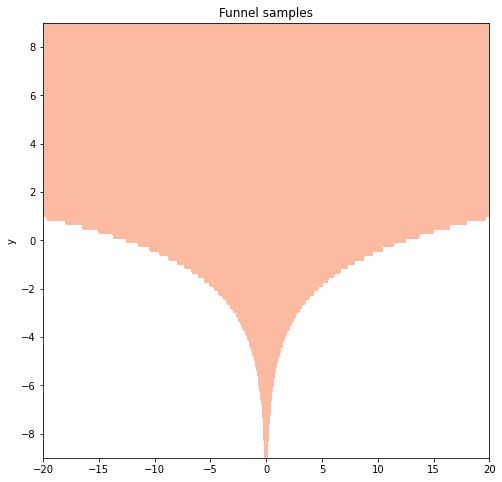

In [43]:
def funnel_pdf(pos):
    prob = dist.Normal(0,3).log_prob(pos[:,:,1]) + dist.Normal(0, np.exp(pos[:,:,1]/2)).log_prob(pos[:,:,0])
    return np.exp(-prob)/np.linalg.norm(np.exp(-prob))
x, y = np.meshgrid(np.linspace(-20, 20, 500), np.linspace(-9, 9, 100))
probs = funnel_pdf(np.stack([x, y], axis=-1))
print(probs)
# make plots
fig, ax = plt.subplots(1, 1, figsize=(8,8))
ax.contourf(x,y,probs,cmap='Reds',)  # contour of funnel
ax.plot(svgd.get_params(svgd_state)['auto_x'][:, 0], svgd.get_params(svgd_state)['auto_y'], "go", alpha=0.3)
ax.set(xlim=(-20, 20), ylim=(-9, 9), ylabel='y', title='Funnel samples')
plt.show()